Trial 90 Complete [00h 00m 42s]
val_accuracy: 0.8974166512489319

Best val_accuracy So Far: 0.8982499837875366
Total elapsed time: 00h 25m 04s
Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7771 - loss: 0.6298 - val_accuracy: 0.8533 - val_loss: 0.4047
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8644 - loss: 0.3635 - val_accuracy: 0.8697 - val_loss: 0.3641
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8788 - loss: 0.3216 - val_accuracy: 0.8780 - val_loss: 0.3351
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8892 - loss: 0.2964 - val_accuracy: 0.8730 - val_loss: 0.3407
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8962 - loss: 0.2739 - val_accuracy: 0.8851 - val_loss: 0.3140
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9002 - loss: 0.2576 - val_accuracy: 0.8861 - val_loss: 0.3258
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9037 - lo

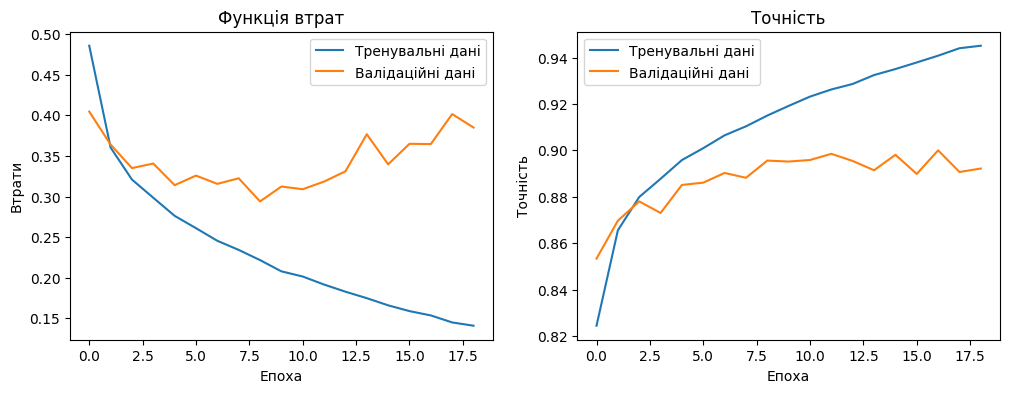

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Класифікаційний звіт:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1000
           1       0.99      0.98      0.98      1000
           2       0.73      0.88      0.79      1000
           3       0.87      0.91      0.89      1000
           4       0.84      0.75      0.79      1000
           5       0.97      0.96      0.97      1000
           6       0.77      0.66      0.71      1000
           7       0.96      0.95      0.96      1000
           8       0.98      0.96      0.97      1000
           9       0.95      0.97      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000


Найкращі гіперпараметри:
Кількість шарів: 3
Кількість нейронів у шарі 1: 416
Кількість нейронів у шарі 2: 384
Кількість нейронів у шарі 3: 512
Швидкість навчання: 0.00046309574

In [1]:
""" Побудувати нейронну мережу, аналогічну завданню 1 для датасета fashion
mnist """
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
from sklearn.metrics import classification_report
import kerastuner as kt

(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

train_images = train_images.astype("float32") / 255
test_images = test_images.astype("float32") / 255

train_labels_cat = keras.utils.to_categorical(train_labels)
test_labels_cat = keras.utils.to_categorical(test_labels)

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28)))
    
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(layers.Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
                               activation='relu'))
    
    model.add(layers.Dense(10, activation='softmax'))
    
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=30,
                     factor=3,
                     directory='my_dir',
                     project_name='fashion_mnist_tuning')

tuner.search(train_images, train_labels_cat,
             epochs=30,
             validation_split=0.2,
             callbacks=[keras.callbacks.EarlyStopping(patience=5)])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

history = model.fit(train_images, train_labels_cat,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)])

test_loss, test_acc = model.evaluate(test_images, test_labels_cat, verbose=2)
print(f"\nТочність на тестових даних: {test_acc:.4f}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Тренувальні дані')
plt.plot(history.history['val_loss'], label='Валідаційні дані')
plt.title('Функція втрат')
plt.xlabel('Епоха')
plt.ylabel('Втрати')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Тренувальні дані')
plt.plot(history.history['val_accuracy'], label='Валідаційні дані')
plt.title('Точність')
plt.xlabel('Епоха')
plt.ylabel('Точність')
plt.legend()
plt.show()

y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
print("\nКласифікаційний звіт:")
print(classification_report(test_labels, y_pred_classes))

print("\nНайкращі гіперпараметри:")
print(f"Кількість шарів: {best_hps.get('num_layers')}")
for i in range(best_hps.get('num_layers')):
    print(f"Кількість нейронів у шарі {i+1}: {best_hps.get(f'units_{i}')}")
print(f"Швидкість навчання: {best_hps.get('learning_rate')}")